In [44]:
# Download data from the llm_evals table at this psql link
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv()
conn_str = os.getenv('PG_STR')


In [45]:

conn = psycopg2.connect(conn_str)

cursor = conn.cursor()

cursor.execute("SELECT * FROM llm_evals where run_name = 'DeepSeek-R1-Distill-Qwen-14B-AWQ-5origprompt-H100-16384-t0.5' or run_name = 'Qwen2.5-R1-Distill-GRPO-h-awq-t0.6-16ctx-16seq-run1'")

results = cursor.fetchall()


In [46]:
conn.close()

# Get omni math

In [47]:
import pandas as pd

omni = pd.read_json("hf://datasets/KbsdJames/Omni-MATH/test.jsonl", lines=True)
# Add p_id
omni["p_id"] = omni.index.astype(str)
omni["p_id"] = omni.apply(lambda row: f"{row['p_id']}_{row['source']}_(omnimath)", axis=1)

In [48]:
omni = omni[omni['answer'].apply(lambda x: x.isdigit())]
omni_valid_ans_ids = omni['p_id'].unique()
omni_id_to_ans = dict(zip(omni['p_id'], omni['answer']))

# Parse out the eval'd DF

In [49]:
columns = [i[0] for i in cursor.description]

df = pd.DataFrame(results, columns=columns)

for row in df.itertuples():
    if row.p_id in omni_valid_ans_ids:
        df.at[row.Index, "answer"] = omni_id_to_ans[row.p_id]

In [50]:
from ast import literal_eval
def my_func(x):
    x = literal_eval(x)
    if x[0][1]["role"] != "user":
        raise TypeError()
    return x[0][1]["content"]


df["problem"] = df["reasoning"].apply(my_func)
df["solution"] = df["label"].apply(lambda x: f"\\boxed{{{int(x)}}}")

# Drop the mod 1000 suffix from all aime run questions
suffix = "If the final answer is a number larger than 1000, take modulo 1000. "
df["problem"] = df["problem"].apply(lambda x: x[:-len(suffix)] if x.endswith(suffix) else x)
assert sum(df["problem"].apply(lambda text: text[-13:] == "modulo 1000. ")) == 0

# Drop duplicateds for problem and p_id. Keep the last occurence.
print(f"Before dropping duplicates, len(df) = {len(df)}")
df.drop_duplicates(subset=['problem'],inplace=True,keep='last')
df.drop_duplicates(subset=['p_id'],inplace=True,keep='last')
print(f"AFter dropping duplicates, len(df) = {len(df)}")

# Drop duplicateds for problem and p_id. Keep the last occurence. Create a new column reasoning_parsed
df['reasoning_parsed'] = df['reasoning'].apply(literal_eval)

print("Before filtering out non-integer problems:",len(df))
filter_results = pd.read_csv("problem_filter_results.csv")
valid_ids = filter_results[filter_results["has_integer_solution"] == True]["p_id"].unique()
valid_ids = set(valid_ids)

valid_ones_n_zeros = pd.read_csv("ones_n_zeros_annot.csv")
valid_onz_ids = set(valid_ones_n_zeros[valid_ones_n_zeros["valid"] == 'y']["p_id"].unique())

valid_ids = valid_ids.union(valid_onz_ids)
df = df[df["p_id"].isin(valid_ids)]
print("After filtering out non-integer problems + too easy ones:",len(df))

Before dropping duplicates, len(df) = 2843
AFter dropping duplicates, len(df) = 2825
Before filtering out non-integer problems: 2825
After filtering out non-integer problems + too easy ones: 1372


In [51]:
# Drop rows where label is 0 or 1 - not doing anymore since we've filtered
# df[df['label'].isin([0,1])][['p_id','uuid']].to_csv('ones_n_zeros.csv')

# df = df[~df['label'].isin([0,1])]

In [52]:
from datetime import datetime
import re

def extract_boxed_text(text):
    # Return the last occurrence of "boxed" in the text
    texts = re.findall(r'boxed\{(\d+)\}', text)
    final = texts[-1] if len(texts) > 0 else None
    if not final:
        texts = re.findall(r'(\d+)', text)
        if len(texts) > 0:
            final = texts[-1]
    return int(final) if final and final.isdigit() and len(final) < 100 else None

df["extracted_answers"] = df["extracted_answers"].apply(lambda answers: [answer % 1000 for answer in answers])
df["re_extracted_answers"] = df["reasoning_parsed"].apply(lambda x: [extract_boxed_text(i[-1]["content"]) for i in x if i[-1]["role"] == "assistant"])

# df = df[(df['runtime_s']>100) | (df["run_name"].str.contains("5origprompt"))]

df = df[df['p_id'].isin(omni_valid_ans_ids) | (df["run_name"].str.contains("5origprompt"))]

df["prop_correct_orig"] = df.apply(lambda x: x.extracted_answers.count(x.label)/(len(x.extracted_answers) or 1), axis=1)
df["prop_correct_uniform"] = df.apply(lambda x: x.re_extracted_answers.count(x.label)/(len(x.re_extracted_answers) or 1), axis=1)

In [53]:
print("rows w/ correct answer and lenless than 100s for each extraction method")
sum(df.apply(lambda x: x.label in x.re_extracted_answers and x.runtime_s < 100, axis=1)), sum(df.apply(lambda x: x.label in x.extracted_answers and x.runtime_s < 100, axis=1))

rows w/ correct answer and lenless than 100s for each extraction method


(142, 83)

In [54]:
print("rows w/ correct answer and lenless than 100s for each extraction method, specific to original dataset")
sum(df.apply(lambda x: x.label in x.re_extracted_answers and not ("5origprompt" in x.run_name) and x.runtime_s < 100, axis=1)), sum(df.apply(lambda x: x.label in x.extracted_answers and not ("5origprompt" in x.run_name) and x.runtime_s < 100, axis=1))

rows w/ correct answer and lenless than 100s for each extraction method, specific to original dataset


(96, 37)

# Create levels of difficulty

<Axes: >

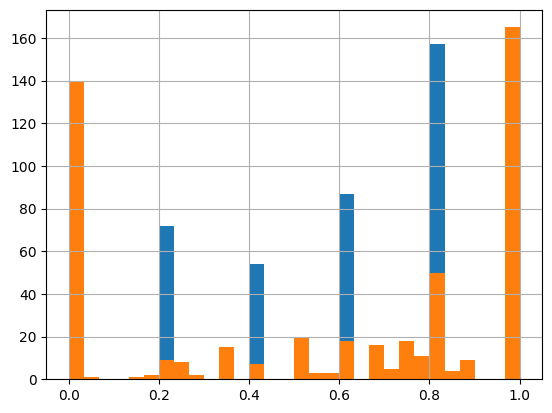

In [55]:
df[df['run_name'].str.contains("5origprompt")]['prop_correct_uniform'].hist(bins=30)
df[df['run_name'].str.contains("5origprompt")]['prop_correct_orig'].hist(bins=30, )

<Axes: >

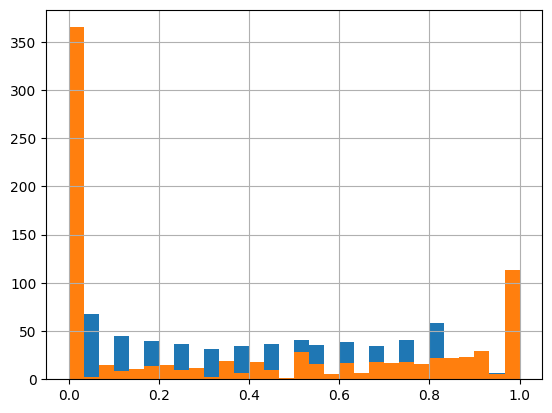

In [56]:
df[~df['run_name'].str.contains("5origprompt")]['prop_correct_uniform'].hist(bins=30)
df[~df['run_name'].str.contains("5origprompt")]['prop_correct_orig'].hist(bins=30, )

In [57]:
df["prop_correct"] = df["prop_correct_uniform"]

In [58]:
df_easy = df[df["prop_correct"].apply(lambda x: x < 0.8 and x>0.6)]

df_medium = df[df["prop_correct"].apply(lambda x: x <= 0.6 and x>0.35)]
df_hard = df[df["prop_correct"].apply(lambda x: x <= 0.35 and x>0.1)]
df_damn = df[df["prop_correct"].apply(lambda x: x <=0.1)]

In [59]:
len(df_easy), len(df_medium), len(df_hard), len(df_damn)

(114, 289, 225, 482)

<Axes: >

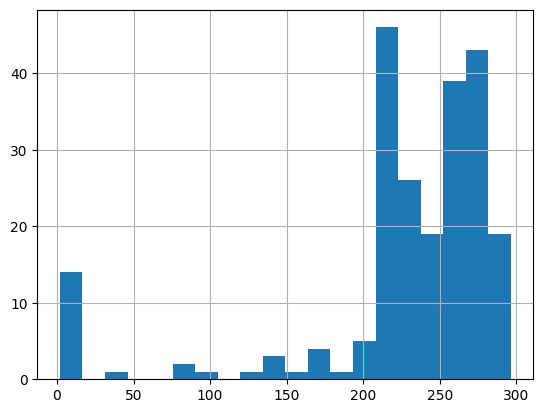

In [60]:
df_hard['runtime_s'].hist(bins=20)

In [61]:
df_hard[(df_hard['runtime_s'] < 240) * (df_hard['runtime_s'] > 210)]['run_name'].value_counts()

run_name
DeepSeek-R1-Distill-Qwen-14B-AWQ-5origprompt-H100-16384-t0.5    59
Qwen2.5-R1-Distill-GRPO-h-awq-t0.6-16ctx-16seq-run1             10
Name: count, dtype: int64

<Axes: >

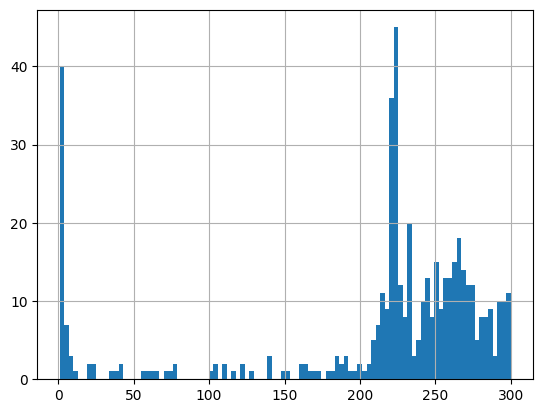

In [62]:
df_damn['runtime_s'].hist(bins=100)

<Axes: >

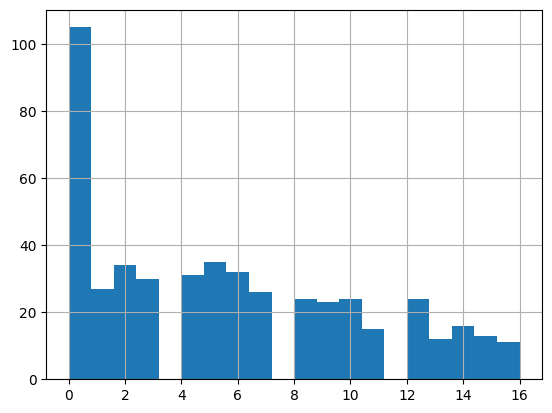

In [63]:
df_damn['extracted_answers'].apply(len).hist(bins=20)

In [64]:
simple_and_empty_indices = (df_damn['extracted_answers'].apply(len) == 0) * (df_damn['runtime_s'] < 100)

df_damn = df_damn[~simple_and_empty_indices]
df_hell = df_damn[df_damn['extracted_answers'].apply(len) == 0]

In [79]:
# Merge all difficulty levels into one DataFrame
df_merged = pd.concat([df_easy, df_medium, df_hard, df_damn])


# Create splits

In [66]:
import numpy as np
# Create val, train splits for each df
# val percentage = 5%

# Set random seed for reproducibility
np.random.seed(42)

# Function to split DataFrame into train and val sets
def train_val_split(df, val_percentage=0.1):
    # Shuffle indices
    indices = np.random.permutation(len(df))
    val_size = int(len(df) * val_percentage)
    
    # Split indices
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    # Create train and val DataFrames
    train_df = df.iloc[train_indices]
    val_df = df.iloc[val_indices]
    
    return train_df, val_df

# Split each difficulty level
df_easy_train, df_easy_val = train_val_split(df_easy)
df_medium_train, df_medium_val = train_val_split(df_medium)
df_hard_train, df_hard_val = train_val_split(df_hard)
df_damn_train, df_damn_val = train_val_split(df_damn)
df_hell_train, df_hell_val = train_val_split(df_hell)

print(f"Easy dataset sizes - Total: {len(df_easy)}, Train: {len(df_easy_train)}, Val: {len(df_easy_val)}")
print(f"Medium dataset sizes - Total: {len(df_medium)}, Train: {len(df_medium_train)}, Val: {len(df_medium_val)}")
print(f"Hard dataset sizes - Total: {len(df_hard)}, Train: {len(df_hard_train)}, Val: {len(df_hard_val)}")
print(f"Damn dataset sizes - Total: {len(df_damn)}, Train: {len(df_damn_train)}, Val: {len(df_damn_val)}")
print(f"Hell dataset sizes - Total: {len(df_hell)}, Train: {len(df_hell_train)}, Val: {len(df_hell_val)}")

Easy dataset sizes - Total: 114, Train: 103, Val: 11
Medium dataset sizes - Total: 289, Train: 261, Val: 28
Hard dataset sizes - Total: 225, Train: 203, Val: 22
Damn dataset sizes - Total: 431, Train: 388, Val: 43
Hell dataset sizes - Total: 54, Train: 49, Val: 5


In [67]:
# Write val datasets to file for examination
# val_sets
# |
# `--> {difficulty}
#       |
#       `--> { p_id }.txt

import os

# Create directories for each difficulty level
difficulties = ['easy', 'medium', 'hard', 'damn', 'hell']
val_dfs = [df_easy_val, df_medium_val, df_hard_val, df_damn_val, df_hell_val]

# Create base directory for validation sets
base_dir = 'val_sets'
os.makedirs(base_dir, exist_ok=True)

# Write validation sets for each difficulty
for difficulty, val_df in zip(difficulties, val_dfs):
    # Create directory for this difficulty
    diff_dir = os.path.join(base_dir, difficulty)
    os.makedirs(diff_dir, exist_ok=True)
    
    # Write each problem to a separate file
    for _, row in val_df.iterrows():
        problem_file = os.path.join(diff_dir, f"{row['p_id']}.txt")
        with open(problem_file, 'w') as f:
            f.write(f"Problem ID: {row['p_id']}\n")
            f.write(f"Question: {row['problem']}\n")

In [ ]:
df_

In [68]:
import math

for i, row in df_merged.iterrows():
    if str(row['answer']).isdigit() and int(row['answer']) != int(row['label']):
        print(f"Omni Answer: {row['answer']}, Dset Answer: {row['label']}")

Omni Answer: 1000, Dset Answer: 0.0
Omni Answer: 334000, Dset Answer: 0.0
Omni Answer: 10000, Dset Answer: 0.0
Omni Answer: 1000, Dset Answer: 0.0
Omni Answer: 1000, Dset Answer: 0.0
Omni Answer: 3920000, Dset Answer: 0.0


In [ ]:
df_merged.to_csv("math_full.csv")


In [74]:
df_merged.columns

Index(['uuid', 'exec_time', 'runtime_s', 'p_id', 'run_name', 'prediction',
       'label', 'extracted_answers', 'reasoning', 'answer', 'problem',
       'solution', 'reasoning_parsed', 're_extracted_answers',
       'prop_correct_orig', 'prop_correct_uniform', 'prop_correct'],
      dtype='object')

In [123]:
from tqdm import tqdm

new_df_dict = {"id": [], "reasoning": [], "problem": []}
for i, row in tqdm(df_merged.iterrows()):
    p_id = row['p_id']
    for j, convo in enumerate(row['reasoning_parsed']):
        reasoning = convo[-1]["content"]
        problem = convo[1]["content"]
        new_df_dict["reasoning"].append(reasoning)
        new_df_dict["id"].append(f"{j}--{p_id}")
        new_df_dict["problem"].append(problem)

new_df = pd.DataFrame.from_dict(new_df_dict)

1059it [00:00, 34792.10it/s]


In [124]:
import pandas as pd
import re

def remove_surrogate_rows(df, column_name):
    # Check for surrogate pairs (U+D800 to U+DFFF)
    surrogate_pattern = re.compile(r'[\uD800-\uDFFF]')
    
    # Create mask where False means the row contains surrogate pairs
    mask = ~df[column_name].fillna('').astype(str).apply(
        lambda x: bool(surrogate_pattern.search(x))
    )
    
    # Return filtered dataframe
    return df[mask]

# Alternative approach that doesn't use regex
def filter_no_surrogates(df, column_name):
    def has_no_surrogates(text):
        if not isinstance(text, str):
            return True
        
        # Check if any character is in the surrogate range
        for char in text:
            if 0xD800 <= ord(char) <= 0xDFFF:
                return False
        return True
    
    return df[df[column_name].apply(has_no_surrogates)]
new_df = remove_surrogate_rows(new_df, "reasoning")


In [126]:
new_df = new_df[new_df["reasoning"].apply(lambda x: "\\boxed{" in x or len(x) > 12000) ]
new_df.to_csv('traces.csv')

In [130]:
new_df.columns

Index(['id', 'reasoning', 'problem'], dtype='object')

In [128]:
new_df.columns

Index(['id', 'reasoning', 'problem'], dtype='object')

In [36]:
# We're going to train one pass without eval dsets and with the un-modded answer.

# The next pass, we're going to train WITH eval dsets and with the *modded* answer

# the first and second pass versions will have respective prefixes 'pass1_' and 'pass2_'

# Remove all columns except for problem and label
columns_to_remove = ['uuid', 'exec_time', 'runtime_s', 'p_id', 'run_name', 'prediction',
       'label', 'extracted_answers', 'reasoning', 'answer', 
       'reasoning_parsed', 're_extracted_answers', 'prop_correct_orig',
       'prop_correct_uniform', 'prop_correct']

df_easy_train = df_easy_train.drop(columns=columns_to_remove)
df_easy_val = df_easy_val.drop(columns=columns_to_remove)
df_easy = df_easy.drop(columns=columns_to_remove)

df_medium_train = df_medium_train.drop(columns=columns_to_remove)
df_medium_val = df_medium_val.drop(columns=columns_to_remove)
df_medium = df_medium.drop(columns=columns_to_remove)

df_hard_train = df_hard_train.drop(columns=columns_to_remove)
df_hard_val = df_hard_val.drop(columns=columns_to_remove)
df_hard = df_hard.drop(columns=columns_to_remove)

df_damn_train = df_damn_train.drop(columns=columns_to_remove)
df_damn_val = df_damn_val.drop(columns=columns_to_remove)
df_damn = df_damn.drop(columns=columns_to_remove)

df_hell_train = df_hell_train.drop(columns=columns_to_remove)
df_hell_val = df_hell_val.drop(columns=columns_to_remove)
df_hell = df_hell.drop(columns=columns_to_remove)

In [43]:
df_merged.columns

Index(['problem', 'solution'], dtype='object')

In [280]:
# Convert to huggingface dataset
from datasets import Dataset

hf_tok = os.getenv("HF_TOK")

# Convert pandas DataFrame to Huggingface Dataset
easy_train = Dataset.from_pandas(df_easy_train, split="train")
easy_val = Dataset.from_pandas(df_easy_train, split="test")

easy_val.to_csv("easy_val.csv")

# Push to hub
easy_train.push_to_hub(
    "samitizerxu/easy-pass1",
    private=True,
    token=hf_tok  # Replace with actual token
)

easy_val.push_to_hub(
    "samitizerxu/easy-pass1", 
    private=True,
    token=hf_tok
)

medium_train = Dataset.from_pandas(df_medium_train, split="train")
medium_val = Dataset.from_pandas(df_medium_val, split="test")

medium_val.to_csv("medium_val.csv")

medium_train.push_to_hub(
    "samitizerxu/medium-pass1",
    private=True, 
    token=hf_tok
)

medium_val.push_to_hub(
    "samitizerxu/medium-pass1",
    private=True,
    token=hf_tok
)

hard_train = Dataset.from_pandas(df_hard_train, split="train")
hard_val = Dataset.from_pandas(df_hard_val, split="test") 

hard_val.to_csv("hard_val.csv")

hard_train.push_to_hub(
    "samitizerxu/hard-pass1",
    private=True,
    token=hf_tok
)

hard_val.push_to_hub(
    "samitizerxu/hard-pass1",
    private=True,
    token=hf_tok
)

damn_train = Dataset.from_pandas(df_damn_train, split="train")
damn_val = Dataset.from_pandas(df_damn_val, split="test")

damn_val.to_csv("damn_val.csv")

damn_train.push_to_hub(
    "samitizerxu/damn-pass1", 
    private=True,
    token=hf_tok
)

damn_val.push_to_hub(
    "samitizerxu/damn-pass1",
    private=True,
    token=hf_tok
)

hell_train = Dataset.from_pandas(df_hell_train, split="train")
hell_val = Dataset.from_pandas(df_hell_val, split="test")

hell_val.to_csv("hell_val.csv")

hell_train.push_to_hub(
    "samitizerxu/hell-pass1",
    private=True,
    token=hf_tok
)

hell_val.push_to_hub(
    "samitizerxu/hell-pass1",
    private=True,
    token=hf_tok
)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/541 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/541 [00:00<?, ?B/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/541 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/541 [00:00<?, ?B/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/537 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/538 [00:00<?, ?B/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/542 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/542 [00:00<?, ?B/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/534 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/534 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/samitizerxu/hell-pass1/commit/c401d7afbd8c4cd864e6277f100bebe372905c22', commit_message='Upload dataset', commit_description='', oid='c401d7afbd8c4cd864e6277f100bebe372905c22', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/samitizerxu/hell-pass1', endpoint='https://huggingface.co', repo_type='dataset', repo_id='samitizerxu/hell-pass1'), pr_revision=None, pr_num=None)

In [ ]:
easy_full = Dataset.from_pandas(df_easy, split='train')

easy_full.push_to_hub(
    "samitizerxu/easy-pass2",
    private=True,
    token=hf_tok
)

medium_full = Dataset.from_pandas(df_medium, split='train')

medium_full.push_to_hub(
    "samitizerxu/medium-pass2",
    private=True,
    token=hf_tok
)

hard_full = Dataset.from_pandas(df_hard, split='train')

hard_full.push_to_hub(
    "samitizerxu/hard-pass2",
    private=True,
    token=hf_tok
)


damn_full = Dataset.from_pandas(df_damn, split='train')

damn_full.push_to_hub(
    "samitizerxu/damn-pass2",
    private=True,
    token=hf_tok
)

hell_full = Dataset.from_pandas(df_hell, split='train')

hell_full.push_to_hub(
    "samitizerxu/hell-pass2",
    private=True,
    token=hf_tok
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/samitizerxu/hell-pass2/commit/2d52738084510c0df298adbdaa5e6a99df270076', commit_message='Upload dataset', commit_description='', oid='2d52738084510c0df298adbdaa5e6a99df270076', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/samitizerxu/hell-pass2', endpoint='https://huggingface.co', repo_type='dataset', repo_id='samitizerxu/hell-pass2'), pr_revision=None, pr_num=None)

In [276]:
df_easy_medium_hard = pd.merge()

Index(['uuid', 'exec_time', 'runtime_s', 'p_id', 'run_name', 'prediction',
       'label', 'extracted_answers', 'reasoning', 'answer', 'problem',
       'solution', 'reasoning_parsed', 're_extracted_answers',
       'prop_correct_orig', 'prop_correct_uniform', 'prop_correct'],
      dtype='object')

In [41]:
len(df_merged)

628

In [39]:
full = Dataset.from_pandas(df_merged, split='train')

full.push_to_hub(
    "samitizerxu/full_math",
    private=True,
    token=hf_tok
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/356 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/samitizerxu/full_math/commit/a905ee010d276f5c5df277c7b55a920d62434fd2', commit_message='Upload dataset', commit_description='', oid='a905ee010d276f5c5df277c7b55a920d62434fd2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/samitizerxu/full_math', endpoint='https://huggingface.co', repo_type='dataset', repo_id='samitizerxu/full_math'), pr_revision=None, pr_num=None)

In [133]:
df_merged.apply(lambda row: row['label'] in row['extracted_answers'][:7], axis=1).mean()

np.float64(0.5637393767705382)